In [1]:
from dataset import *
from moco_model import MoCo
from train import *
import tqdm
from utils import torch_fix_seed


In [2]:
torch_fix_seed(19981303)

In [3]:
path_stem = '../datasets/NDI_images/Integreted/Observed/'
parameters = {'original_image': [path_stem + '', path_stem + 'normalized_pics', path_stem + 'circle_masked_pics', 
                                 path_stem + 'circle_centrosysmmetric_pics']}
list(itertools.product(*parameters.values()))

[('../datasets/NDI_images/Integreted/Observed/',),
 ('../datasets/NDI_images/Integreted/Observed/normalized_pics',),
 ('../datasets/NDI_images/Integreted/Observed/circle_masked_pics',),
 ('../datasets/NDI_images/Integreted/Observed/circle_centrosysmmetric_pics',)]

In [4]:
def get_self_pretrain_model(index=1000):
    base_encoder = torchvision.models.resnet50(weights=None)
    base_encoder.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    origin_dim_mlp = base_encoder.fc.in_features
    base_encoder.fc = None
    temp = torch.load(f'./checkpoints/CEM_ALL_CHECK_{index}_Epoch.pth')['state_dict']
    state_dict = {}
    for k, v in temp.items():
        if 'encoder_q' in k:
            if 'fc' not in k:
                state_dict['.'.join(k.split('.')[1:])] = v
    base_encoder.load_state_dict(state_dict)
    base_encoder.fc = torch.nn.Linear(origin_dim_mlp, 512)
    return base_encoder

def get_pretrain_model():
    base_encoder = torchvision.models.resnet50(weights=None)
    base_encoder.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    origin_dim_mlp = base_encoder.fc.in_features
    base_encoder.fc = None
    base_encoder.load_state_dict(torch.load('../../GithubProject/cem-dataset/cem1.5m_swav_resnet50_200ep_balanced.pth.tar')['state_dict'])
    base_encoder.fc = torch.nn.Linear(origin_dim_mlp, 512)
    return base_encoder

In [5]:
path_stem = '../datasets/NDI_images/Integreted/Observed/'

top_k_candidates = (20, 30, 40)
k = 7
temps = 0.7
momentums = 0.99
k_value = 64
# parameters = {'original_image': [path_stem + '', path_stem + 'normalized_pics', path_stem + 'circle_masked_pics', 
#                                  path_stem + 'circle_centrosysmmetric_pics', path_stem + 'circle_binaryzation_pics']}
parameters = {'original_image': [path_stem + '', path_stem + 'direct_circle_masked', path_stem + 'direct_centrosymmetric', 
                                 path_stem + 'masked_centrosymmetric']}
train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], list(parameters.keys()))

parameters = list(itertools.product(*parameters.values()))

for i, parameter in enumerate(parameters):

    ### custom part to get parameters
    ORIGINAL_IMAGE = parameter[0]
    ### END
    
    for j, images in enumerate(k_fold_train_validation_split(ORIGINAL_IMAGE, TARGET_IMAGE, k)):
        train_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug(images, False)
        val_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug(images, True)
        train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
        val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
        model = get_self_pretrain_model(index=800)
        model = MoCo(model, dim=512, K=k_value, T=temps, m=momentums, mlp=True, customized_model=True)
        device = torch.device('cuda:0')
        criterion = nn.CrossEntropyLoss().cuda(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.015, momentum=0.9, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
        start_time = time.time()
        print(f'Parameter Index: {i + 1} / {len(parameters)}, Fold Index: {j + 1} / {k}')
        metrics = train_moco_return_metrics_top_k(model, train_iter, val_iter, criterion, optimizer, 100, device,
                                                    tested_parameter=parameter, k_candidates=top_k_candidates,
                                                    scheduler=scheduler)
        end_time = time.time()
        train_metrics.cal_add(metrics)
train_metrics.cal_divide(k)

Parameter Index: 1 / 4, Fold Index: 1 / 7
Epoch 1, Train_Loss 3.9309597969055177, Val_loss 4.3016743659973145
Train_acc_top_20 0.1	Train_acc_top_30 0.1437	Train_acc_top_40 0.2188	
Val_acc_top_20 0.04	Val_acc_top_30 0.08	Val_acc_top_40 0.08	
Epoch 2, Train_Loss 4.123656320571899, Val_loss 4.320981502532959
Train_acc_top_20 0.125	Train_acc_top_30 0.1812	Train_acc_top_40 0.25	
Val_acc_top_20 0.0	Val_acc_top_30 0.0	Val_acc_top_40 0.08	
Epoch 3, Train_Loss 4.076663398742676, Val_loss 4.38635778427124
Train_acc_top_20 0.125	Train_acc_top_30 0.1812	Train_acc_top_40 0.2375	
Val_acc_top_20 0.0	Val_acc_top_30 0.0	Val_acc_top_40 0.08	
Epoch 4, Train_Loss 3.964506149291992, Val_loss 4.289238452911377
Train_acc_top_20 0.1187	Train_acc_top_30 0.1812	Train_acc_top_40 0.2375	
Val_acc_top_20 0.0	Val_acc_top_30 0.0	Val_acc_top_40 0.08	
Epoch 5, Train_Loss 3.8693157196044923, Val_loss 4.053081035614014
Train_acc_top_20 0.125	Train_acc_top_30 0.1562	Train_acc_top_40 0.2188	
Val_acc_top_20 0.12	Val_acc_top

KeyboardInterrupt: 

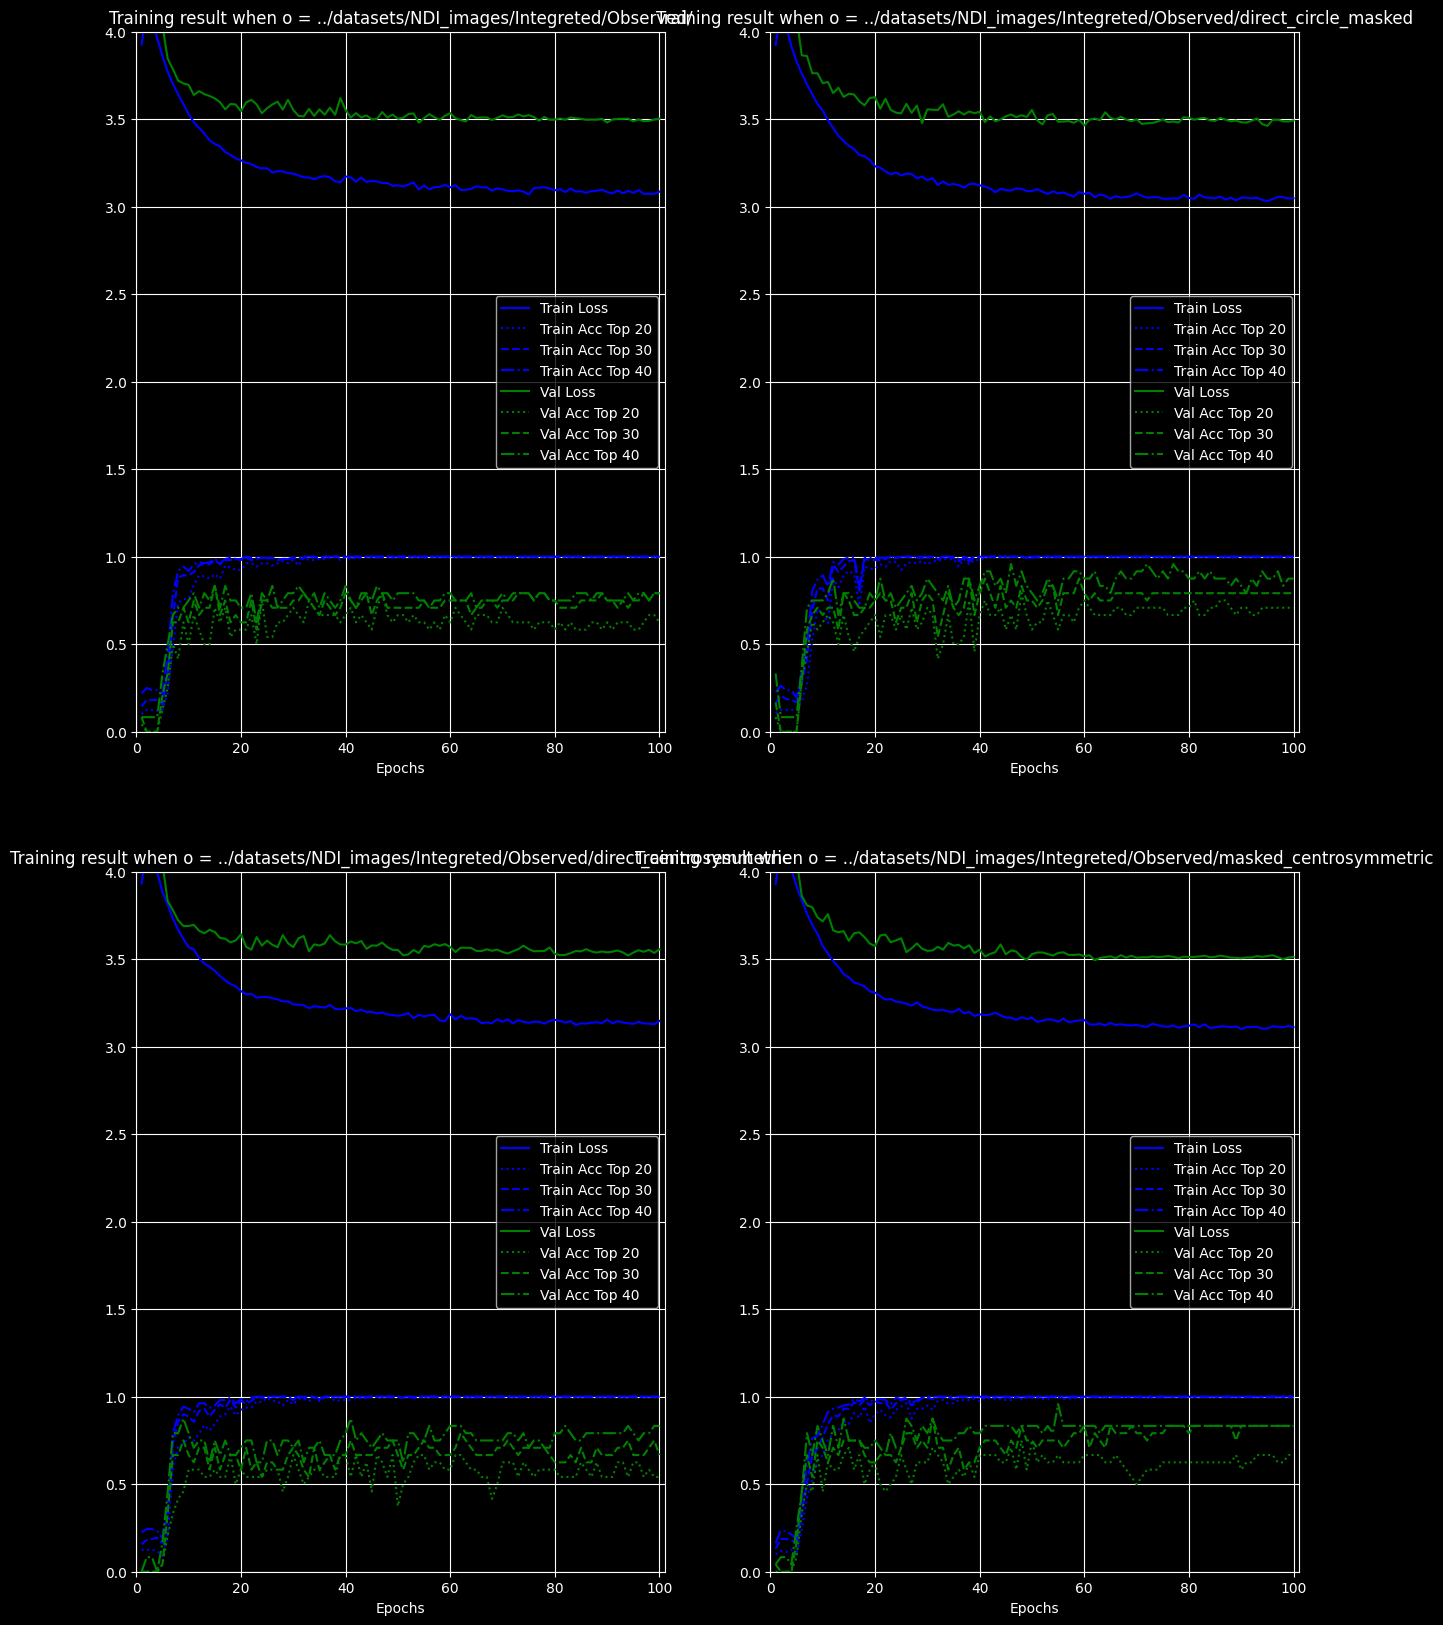

('../datasets/NDI_images/Integreted/Observed/',) 20 mean 0.6152777777777778
('../datasets/NDI_images/Integreted/Observed/',) 20 max 0.7916666666666666
('../datasets/NDI_images/Integreted/Observed/',) 30 mean 0.7541666666666668
('../datasets/NDI_images/Integreted/Observed/',) 30 max 0.8333333333333334
('../datasets/NDI_images/Integreted/Observed/',) 40 mean 0.7722222222222224
('../datasets/NDI_images/Integreted/Observed/',) 40 max 0.8333333333333334
('../datasets/NDI_images/Integreted/Observed/direct_circle_masked',) 20 mean 0.7013888888888886
('../datasets/NDI_images/Integreted/Observed/direct_circle_masked',) 20 max 0.7916666666666666
('../datasets/NDI_images/Integreted/Observed/direct_circle_masked',) 30 mean 0.790277777777778
('../datasets/NDI_images/Integreted/Observed/direct_circle_masked',) 30 max 0.875
('../datasets/NDI_images/Integreted/Observed/direct_circle_masked',) 40 mean 0.8847222222222222
('../datasets/NDI_images/Integreted/Observed/direct_circle_masked',) 40 max 0.95833

<Figure size 640x480 with 0 Axes>

In [6]:
draw_graph(train_metrics.data, 100, ('origin_path'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-30:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

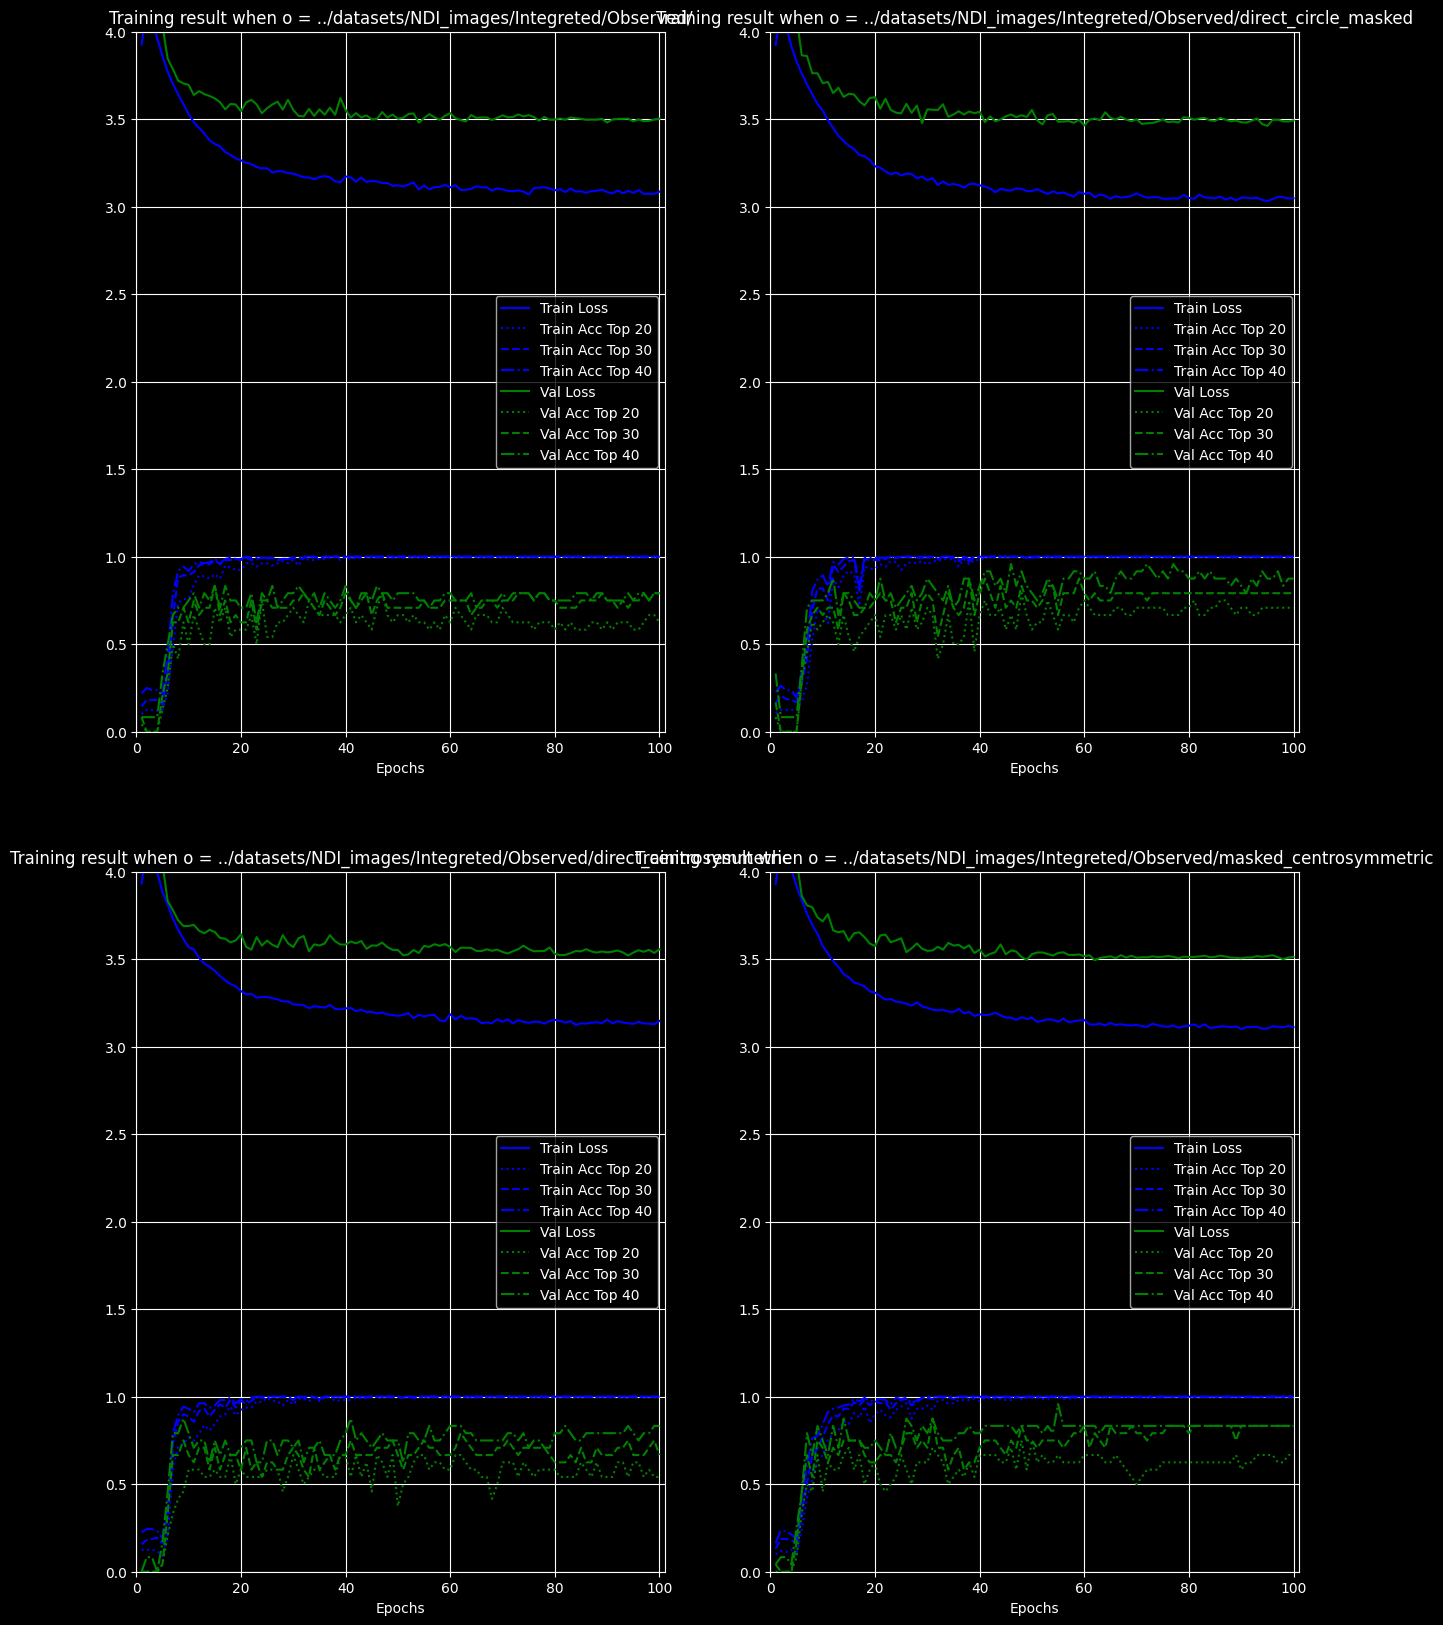

('../datasets/NDI_images/Integreted/Observed/',) 20 mean 0.6152777777777778
('../datasets/NDI_images/Integreted/Observed/',) 20 max 0.7916666666666666
('../datasets/NDI_images/Integreted/Observed/',) 30 mean 0.7541666666666668
('../datasets/NDI_images/Integreted/Observed/',) 30 max 0.8333333333333334
('../datasets/NDI_images/Integreted/Observed/',) 40 mean 0.7722222222222224
('../datasets/NDI_images/Integreted/Observed/',) 40 max 0.8333333333333334
('../datasets/NDI_images/Integreted/Observed/direct_circle_masked',) 20 mean 0.7013888888888886
('../datasets/NDI_images/Integreted/Observed/direct_circle_masked',) 20 max 0.7916666666666666
('../datasets/NDI_images/Integreted/Observed/direct_circle_masked',) 30 mean 0.790277777777778
('../datasets/NDI_images/Integreted/Observed/direct_circle_masked',) 30 max 0.875
('../datasets/NDI_images/Integreted/Observed/direct_circle_masked',) 40 mean 0.8847222222222222
('../datasets/NDI_images/Integreted/Observed/direct_circle_masked',) 40 max 0.95833

<Figure size 640x480 with 0 Axes>

In [5]:
draw_graph(train_metrics.data, 100, ('origin_path'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-30:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

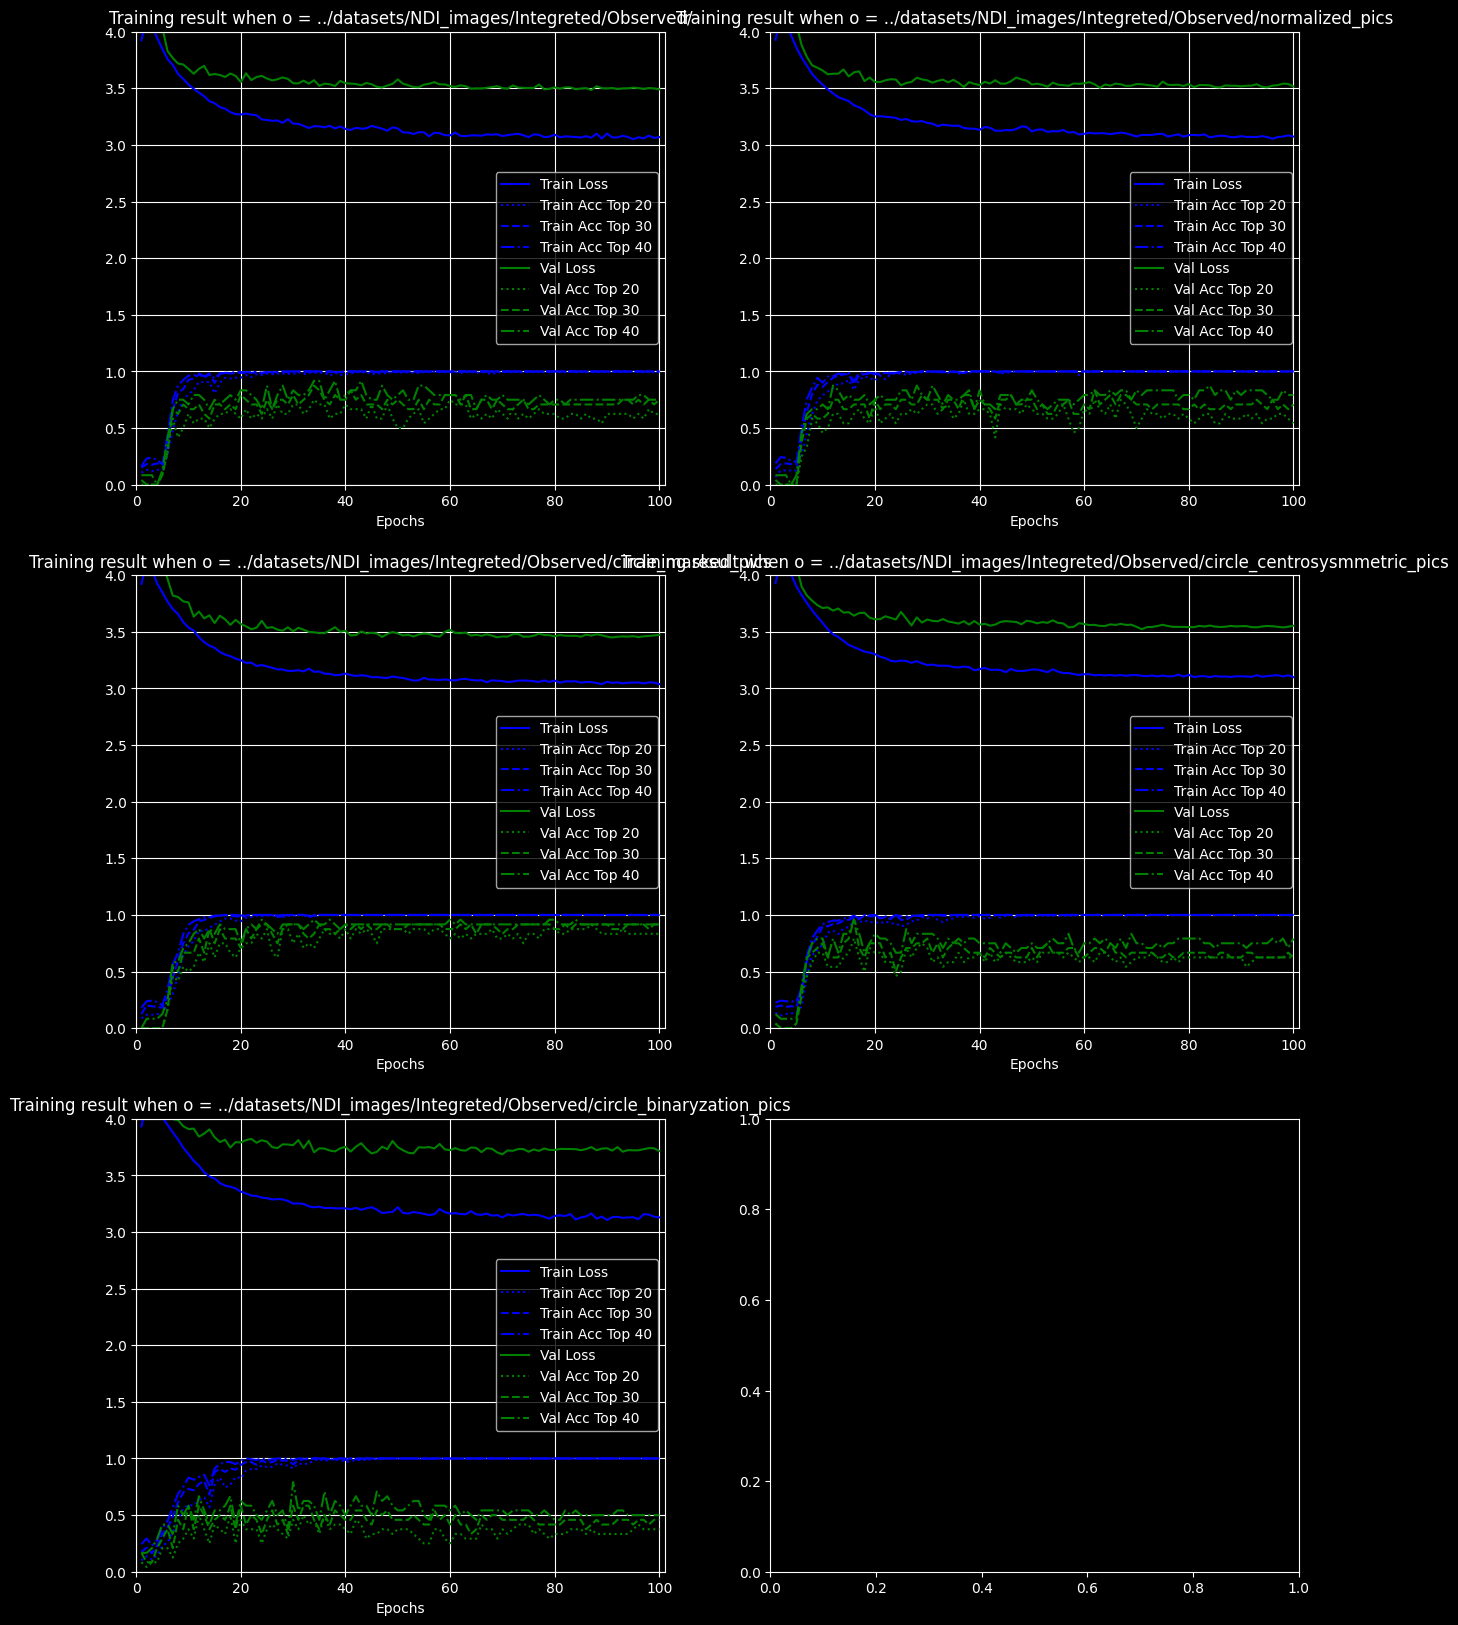

('../datasets/NDI_images/Integreted/Observed/',) 20 mean 0.6125000000000002
('../datasets/NDI_images/Integreted/Observed/',) 20 max 0.75
('../datasets/NDI_images/Integreted/Observed/',) 30 mean 0.711111111111111
('../datasets/NDI_images/Integreted/Observed/',) 30 max 0.875
('../datasets/NDI_images/Integreted/Observed/',) 40 mean 0.7500000000000001
('../datasets/NDI_images/Integreted/Observed/',) 40 max 0.9166666666666666
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 20 mean 0.5958333333333333
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 20 max 0.75
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 30 mean 0.6958333333333334
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 30 max 0.8333333333333334
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 40 mean 0.8097222222222223
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 40 max 0.875
('../datasets/NDI_images/Integreted/Observed/circle_masked_

<Figure size 640x480 with 0 Axes>

In [7]:
draw_graph(train_metrics.data, 100, ('origin_path'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-30:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

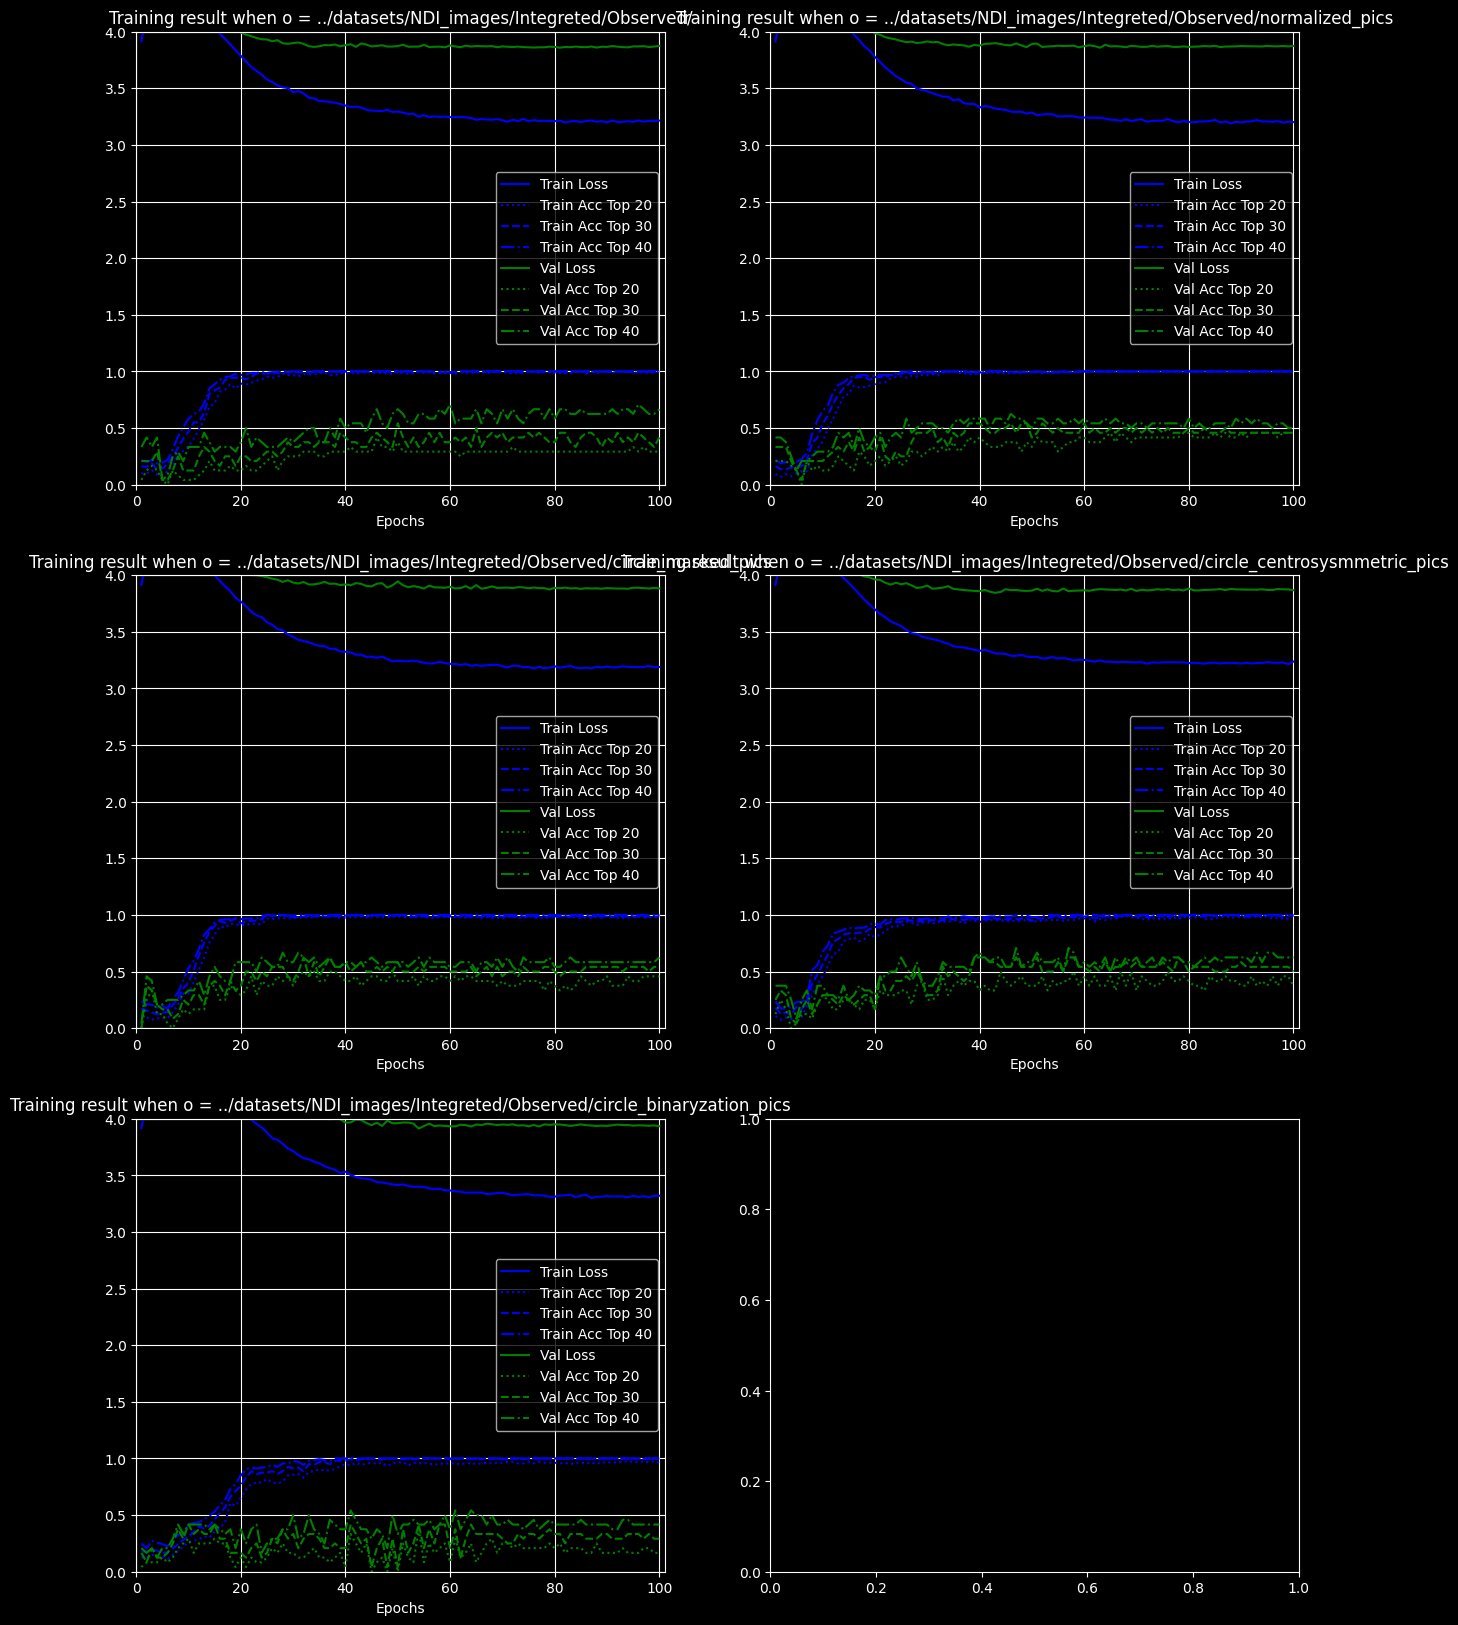

('../datasets/NDI_images/Integreted/Observed/',) 20 mean 0.2958333333333333
('../datasets/NDI_images/Integreted/Observed/',) 20 max 0.4166666666666667
('../datasets/NDI_images/Integreted/Observed/',) 30 mean 0.4083333333333333
('../datasets/NDI_images/Integreted/Observed/',) 30 max 0.5416666666666666
('../datasets/NDI_images/Integreted/Observed/',) 40 mean 0.6361111111111112
('../datasets/NDI_images/Integreted/Observed/',) 40 max 0.7083333333333334
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 20 mean 0.43472222222222234
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 20 max 0.4583333333333333
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 30 mean 0.4666666666666668
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 30 max 0.5416666666666666
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 40 mean 0.5347222222222221
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 40 max 0.625
('../datasets/ND

<Figure size 640x480 with 0 Axes>

In [5]:
draw_graph(train_metrics.data, 100, ('origin_path'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-30:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

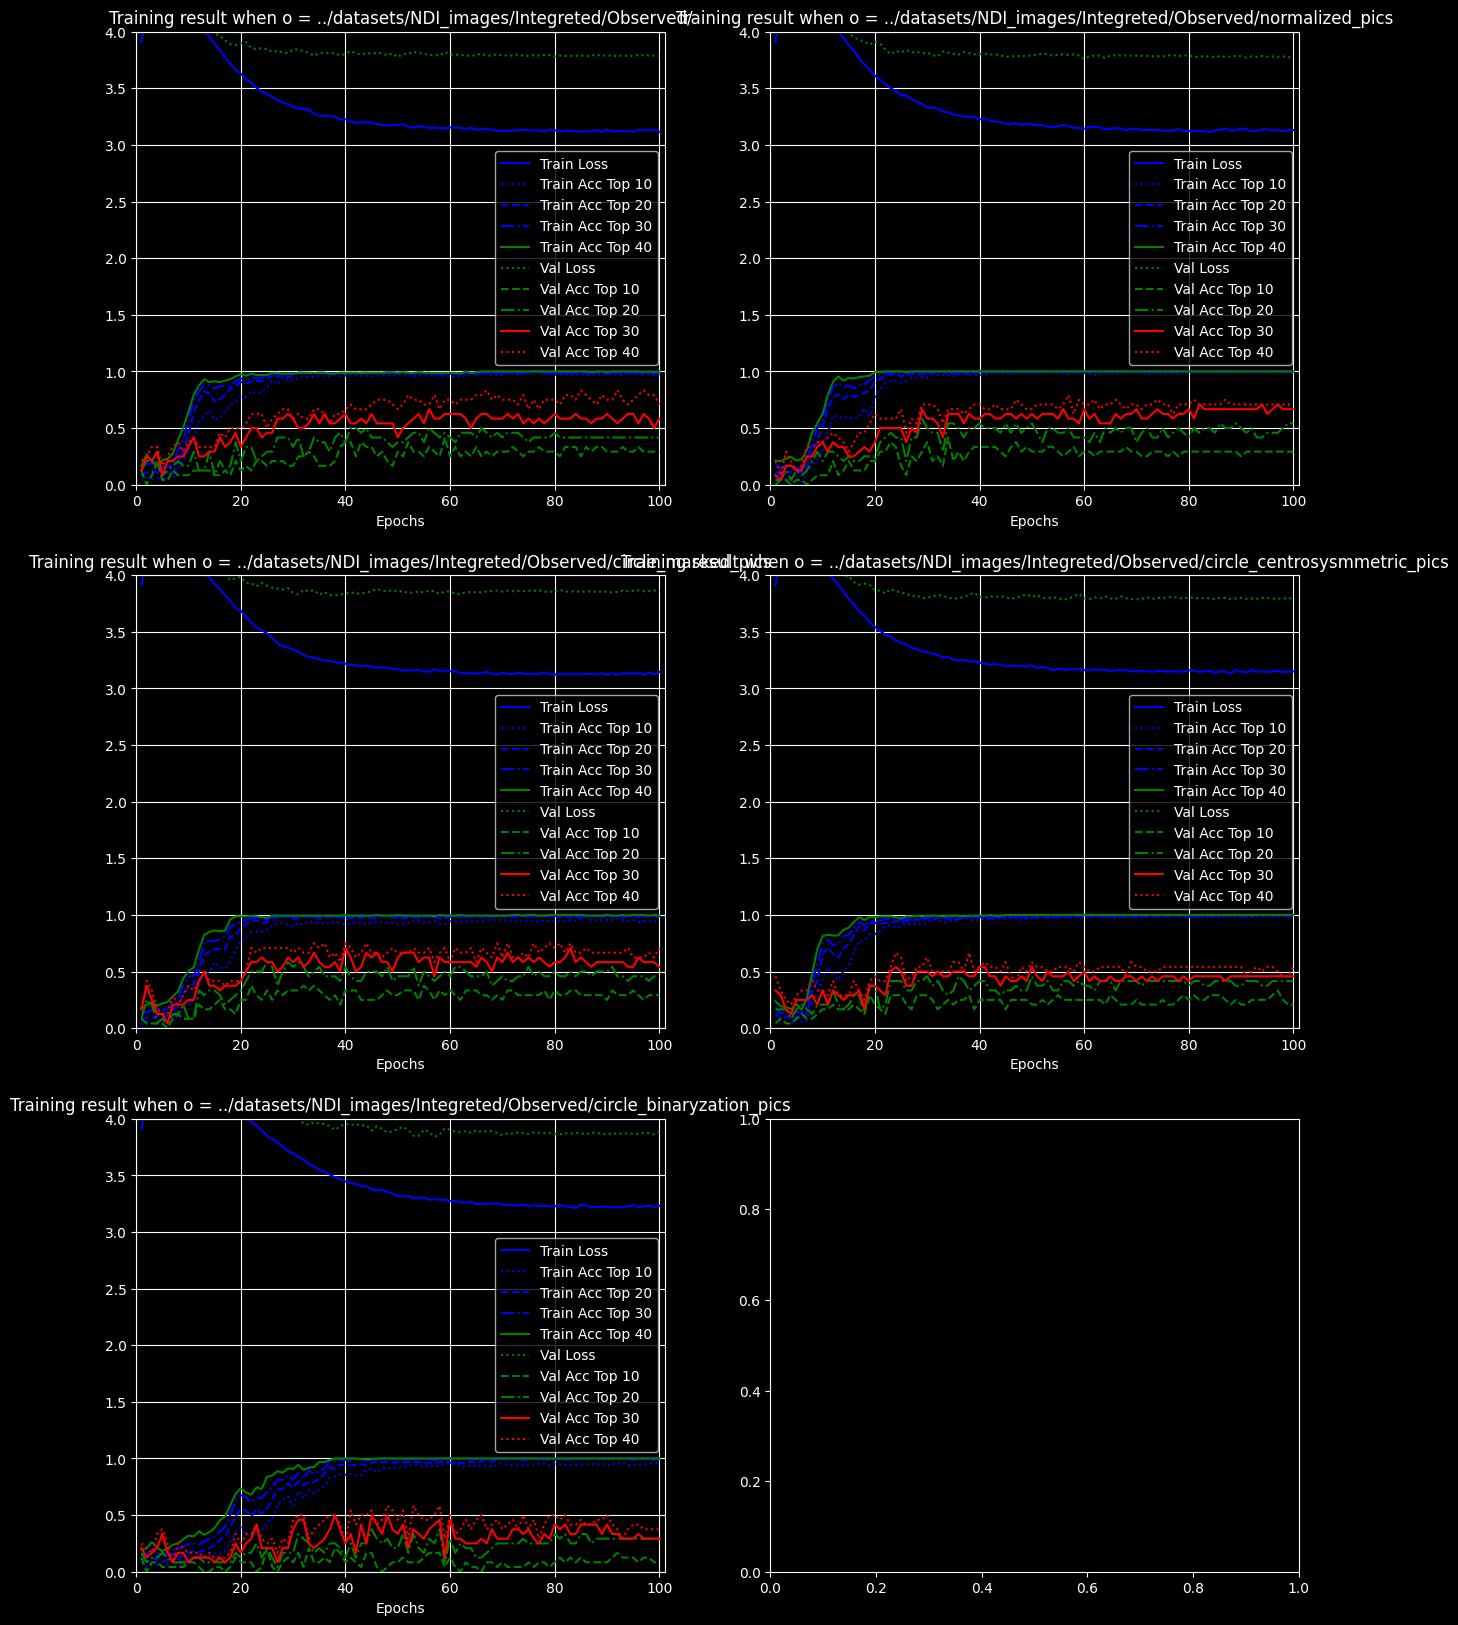

('../datasets/NDI_images/Integreted/Observed/',) 10 mean 0.3013888888888888
('../datasets/NDI_images/Integreted/Observed/',) 10 max 0.4166666666666667
('../datasets/NDI_images/Integreted/Observed/',) 20 mean 0.4208333333333332
('../datasets/NDI_images/Integreted/Observed/',) 20 max 0.5
('../datasets/NDI_images/Integreted/Observed/',) 30 mean 0.5833333333333334
('../datasets/NDI_images/Integreted/Observed/',) 30 max 0.6666666666666666
('../datasets/NDI_images/Integreted/Observed/',) 40 mean 0.7569444444444444
('../datasets/NDI_images/Integreted/Observed/',) 40 max 0.8333333333333334
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 10 mean 0.28472222222222227
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 10 max 0.4166666666666667
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 20 mean 0.47638888888888886
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 20 max 0.5833333333333334
('../datasets/NDI_images/Integreted/Observed/no

<Figure size 640x480 with 0 Axes>

In [7]:
draw_graph(train_metrics.data, 100, ('origin_path'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-30:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

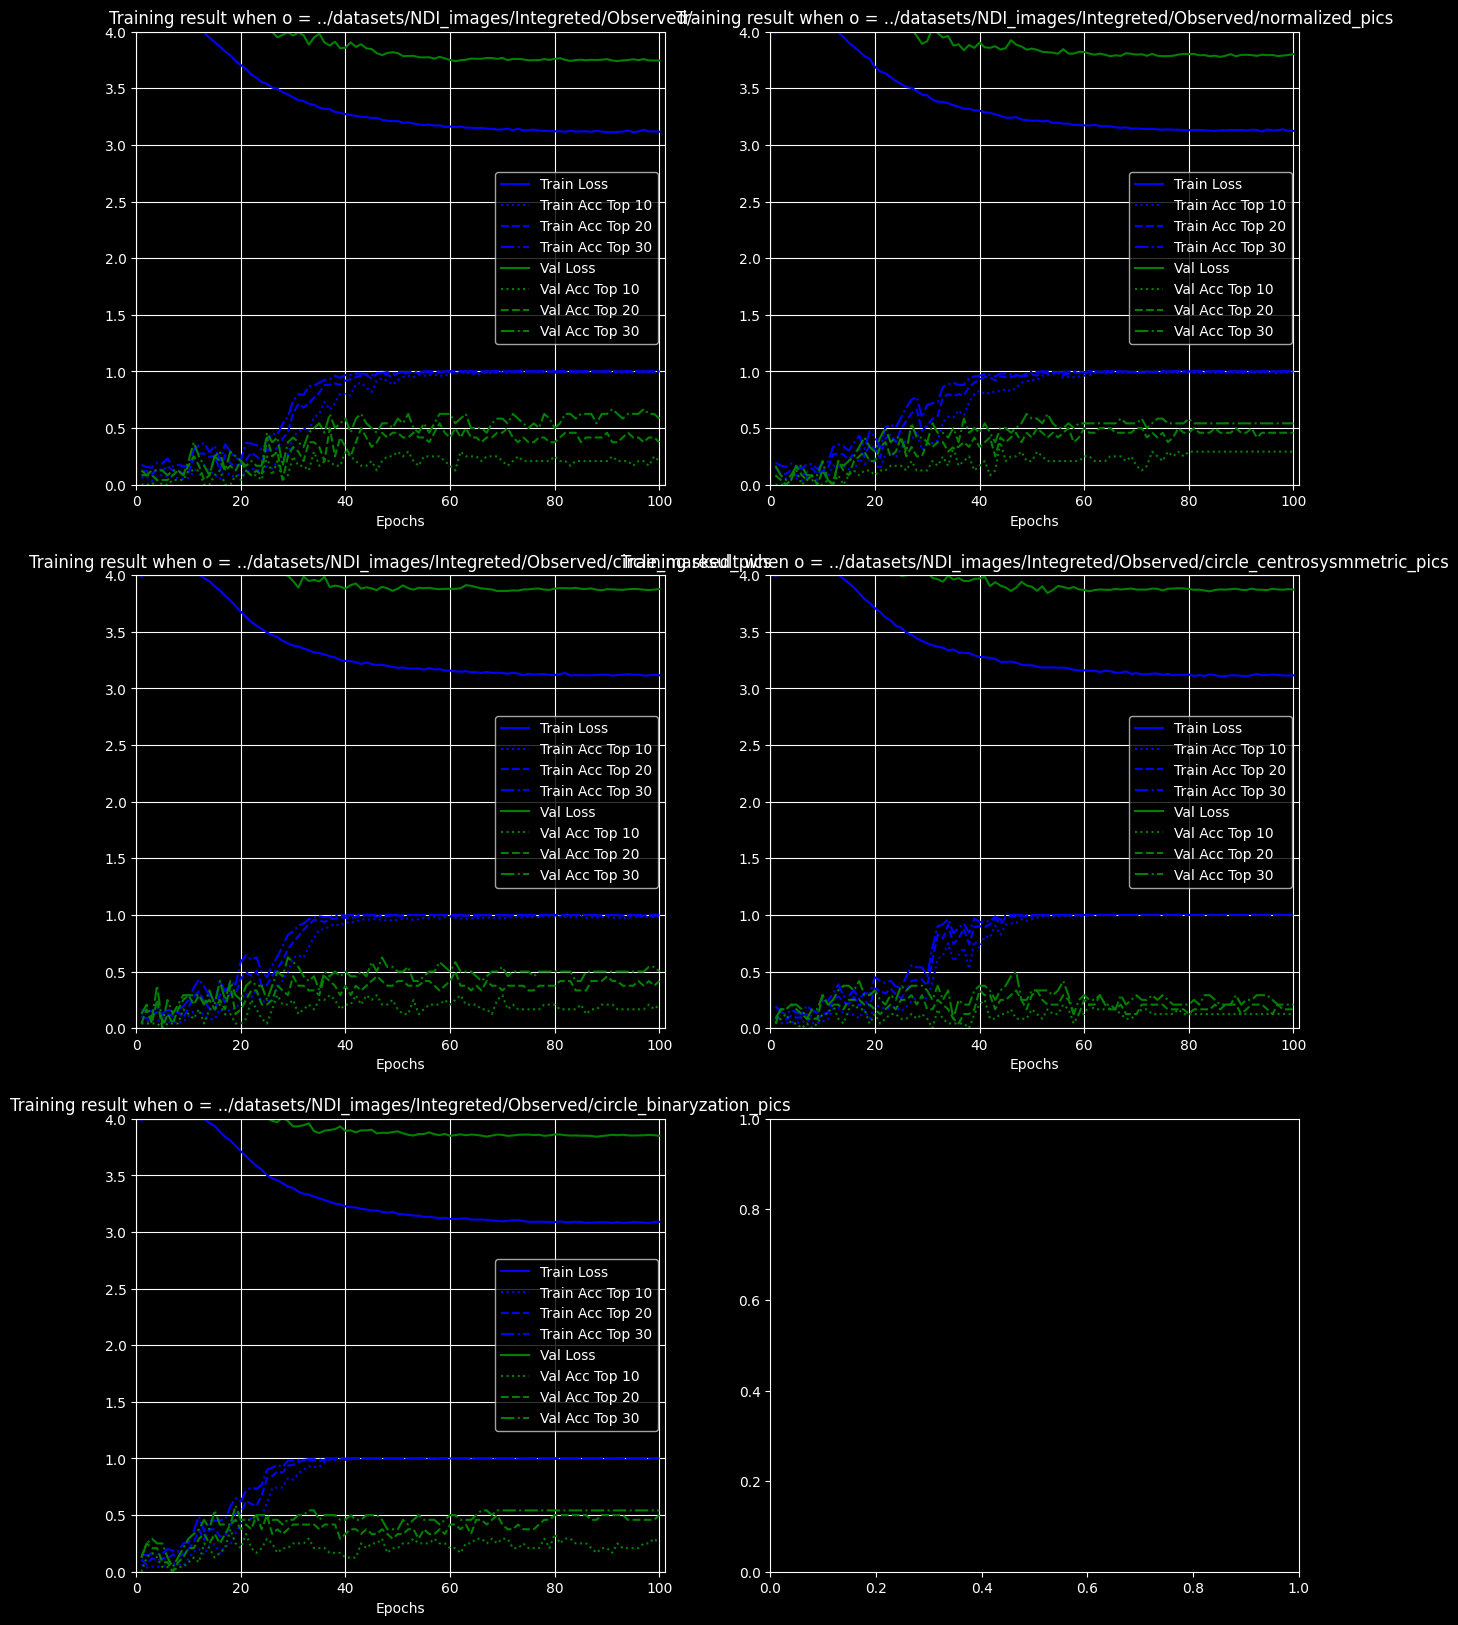

('../datasets/NDI_images/Integreted/Observed/',) 10 mean 0.20833333333333334
('../datasets/NDI_images/Integreted/Observed/',) 10 max 0.2916666666666667
('../datasets/NDI_images/Integreted/Observed/',) 20 mean 0.41249999999999987
('../datasets/NDI_images/Integreted/Observed/',) 20 max 0.5416666666666666
('../datasets/NDI_images/Integreted/Observed/',) 30 mean 0.5944444444444444
('../datasets/NDI_images/Integreted/Observed/',) 30 max 0.6666666666666666
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 10 mean 0.2750000000000001
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 10 max 0.375
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 20 mean 0.4583333333333334
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 20 max 0.5
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 30 mean 0.5458333333333332
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 30 max 0.625
('../datasets/NDI_images/Integreted/Observe

<Figure size 640x480 with 0 Axes>

In [5]:
draw_graph(train_metrics.data, 100, ('origin_path'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-30:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')